## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt


/Users/fazzy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Cleaning and formatting data

In [2]:
#Importing the data
filename = "https://github.com/Nayrbnat/EC1B1-Coursework/raw/main/International_Financial_Statistics.xlsx"
df = pd.read_excel(filename, na_filter = False,header=0)

#Cleaning the data
df = df.transpose()
df.columns = df.iloc[1]
df = df.rename_axis('Date')
df = df[df.index.str.match(r'^[A-Z][a-z]{2} \d{4}$')]
df = df.iloc[0:, 0:].apply(pd.to_numeric) #Changing the data to numeric datatype

#Separating germany and USA data from the dataframes
df_germany = df.iloc[:,0:4]
df_usa = df.iloc[:,4:8]

#Changing the index to date time format
df_germany.index = pd.to_datetime(df_germany.index, format='%b %Y')
df_usa.index = pd.to_datetime(df_germany.index, format='%b %Y')

### Constructing Germany Dataframe

In [3]:
#Inserting new column for monthly growth in nominal exchange rate

df_germany.insert(loc=2, column='Nominal_Monthly_Growth_Exchange_Rate', value = df_germany['Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate'].pct_change() * 100)

#Inserting new column for real exchange rate
#Real Exchange rate = Nominal Exchange Rate in marks/dollars * germany price level / US price level
germany_real_exchange_rate = df_germany['Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate'] / df_usa['Prices, Consumer Price Index, All items, Index'] * df_germany['Prices, Consumer Price Index, All items, Index']
df_germany.insert(loc=5, column='Real_Monthly_Exchange_Rate', value = germany_real_exchange_rate)

#Inserting new column for monthly growth in real exchange rate
df_germany.insert(loc=6, column='Real_Monthly_Growth_Exchange_Rate', value =df_germany['Real_Monthly_Exchange_Rate'].pct_change() * 100)

#Inserting new column for The monthly growth in industrial production
df_germany.insert(loc=1, column='Monthly_Growth_Industrial_Production', value = df_germany['Economic Activity, Industrial Production, Index'].pct_change() * 100)

#Inserting new column for The growth in industrial production versus 12 months ago
df_germany.insert(loc=1, column='Yearly_Growth_Industrial_Production', value = df_germany['Economic Activity, Industrial Production, Index'].pct_change(12) * 100)

#Setting an index of the value of national reserves
df_germany.insert(loc=7, column='Index_National_Reserves', value = (df_germany['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar'] / df_germany['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar'].iloc[0] * 100).fillna(100))

#wewe #Inserting a new column for the monthly inflation rate
df_germany.insert(loc=6, column ='Monthly_Inflation_Rate', value = df_germany['Prices, Consumer Price Index, All items, Index'].pct_change() * 100)

In [4]:
df_germany


Unnamed: 1,"Economic Activity, Industrial Production, Index",Yearly_Growth_Industrial_Production,Monthly_Growth_Industrial_Production,"Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate",Nominal_Monthly_Growth_Exchange_Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Monthly_Inflation_Rate,"Prices, Consumer Price Index, All items, Index",Index_National_Reserves,Real_Monthly_Exchange_Rate,Real_Monthly_Growth_Exchange_Rate
Date,,,,,,,,,,,
1960-01-01,31.214706,NaN,NaN,0.238095,NaN,4724.155785,NaN,24.616929,100.000000,0.436198,NaN
1960-02-01,31.062322,NaN,-0.488181,0.238095,0.000000,4806.362830,-0.568147,24.477068,101.740143,0.432245,-0.906350
1960-03-01,32.225254,NaN,3.743868,0.238095,0.000000,4966.456016,0.000000,24.477068,105.128964,0.432245,0.000000
1960-04-01,34.310512,NaN,6.470881,0.238095,0.000000,5236.120624,0.571393,24.616929,110.837171,0.433241,0.230473
1960-05-01,33.749096,NaN,-1.636279,0.238095,0.000000,5417.091847,0.284096,24.686864,114.667934,0.434472,0.284096
...,...,...,...,...,...,...,...,...,...,...,...
1990-08-01,76.015669,6.017897,-3.590683,0.636659,4.405679,72425.738573,0.311532,67.556702,1533.093782,0.712667,3.775943
1990-09-01,86.554241,5.514275,13.863684,0.637064,0.063706,73197.573621,0.310565,67.766509,1549.431834,0.709406,-0.457573
1990-10-01,92.705752,6.152998,7.107116,0.656470,3.046019,75011.926830,0.722391,68.256049,1587.837706,0.731883,3.168449


### Real Exchange Rate Calculation

$$ RER_{Germany} = NER_{Germany} * \frac{CPI_{Germany}}{CPI_{USA}} $$

where RER = Real Exchange Rate; NER = Nominal Exchange Rate

### Indexing National Reserves

$$ Base Month: Jan 1960 = 100 $$
  

$$  National\,Reserves\,index_{n} = \frac{National\,Reserve\,Value_{n}}{National\,Reserve\,Value_{Jan 1960}} * 100 $$

### Constructing USA Dataframe

In [5]:
#Inserting new column for the monthly inflation rate
df_usa.insert(loc=4, column='Monthly_Inflation_Rate', value = df_usa["Prices, Consumer Price Index, All items, Index"].pct_change() * 100)

#Setting an index of the value of national reserves
df_usa.insert(loc=3, column='Index_National_Reserves', value = (df_usa['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar'] / df_usa['International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar'].iloc[0] * 100).fillna(100))

In [6]:
#Lets view the germany data frame
df_germany


Unnamed: 1,"Economic Activity, Industrial Production, Index",Yearly_Growth_Industrial_Production,Monthly_Growth_Industrial_Production,"Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate",Nominal_Monthly_Growth_Exchange_Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Monthly_Inflation_Rate,"Prices, Consumer Price Index, All items, Index",Index_National_Reserves,Real_Monthly_Exchange_Rate,Real_Monthly_Growth_Exchange_Rate
Date,,,,,,,,,,,
1960-01-01,31.214706,NaN,NaN,0.238095,NaN,4724.155785,NaN,24.616929,100.000000,0.436198,NaN
1960-02-01,31.062322,NaN,-0.488181,0.238095,0.000000,4806.362830,-0.568147,24.477068,101.740143,0.432245,-0.906350
1960-03-01,32.225254,NaN,3.743868,0.238095,0.000000,4966.456016,0.000000,24.477068,105.128964,0.432245,0.000000
1960-04-01,34.310512,NaN,6.470881,0.238095,0.000000,5236.120624,0.571393,24.616929,110.837171,0.433241,0.230473
1960-05-01,33.749096,NaN,-1.636279,0.238095,0.000000,5417.091847,0.284096,24.686864,114.667934,0.434472,0.284096
...,...,...,...,...,...,...,...,...,...,...,...
1990-08-01,76.015669,6.017897,-3.590683,0.636659,4.405679,72425.738573,0.311532,67.556702,1533.093782,0.712667,3.775943
1990-09-01,86.554241,5.514275,13.863684,0.637064,0.063706,73197.573621,0.310565,67.766509,1549.431834,0.709406,-0.457573
1990-10-01,92.705752,6.152998,7.107116,0.656470,3.046019,75011.926830,0.722391,68.256049,1587.837706,0.731883,3.168449


In [7]:
#Lets view the usa data frame
df_usa


Unnamed: 1,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Index_National_Reserves,"Prices, Consumer Price Index, All items, Index",Monthly_Inflation_Rate
Date,,,,,,
1960-01-01,26.794824,1.0,21478.100000,100.000000,13.436946,NaN
1960-02-01,26.944960,1.0,21395.700000,99.616353,13.482806,0.341297
1960-03-01,26.883139,1.0,21344.700000,99.378902,13.482806,0.000000
1960-04-01,26.671183,1.0,21278.000000,99.068353,13.528666,0.340136
1960-05-01,26.609362,1.0,21234.300000,98.864890,13.528666,0.000000
...,...,...,...,...,...,...
1990-08-01,69.548201,1.0,78908.838357,367.392080,60.351608,0.920245
1990-09-01,70.078092,1.0,80024.166133,372.584941,60.856066,0.835866
1990-10-01,69.133119,1.0,82852.196532,385.751982,61.222946,0.602864


## Identifying Outliers

In [8]:
#The code below attempts to remove the outliers and set the values as NA
def get_outliers_lists(df):
    outliers_df = pd.DataFrame()
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_values = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()
        
        if outlier_values:  # Check if there are any outliers
            outlier_values_df = pd.DataFrame({'Outlier_Value': outlier_values, 'Outlier_Column': column})
            outlier_values_df.index = df.index[df[column].isin(outlier_values)]
            outliers_df = pd.concat([outliers_df, outlier_values_df])
    
    return outliers_df

**Explaining the function**

$$IQR = Interquartile\,range$$

Our criteria for an outlier is adopted from the Tukey's fences method. This refers to data points that lie 1.5 * IQR below the first quartile (Q1) or above the third quartile (Q3).

This function goes through data from columns which are of the numerical datatype and classifies them based on the criteria above and adds them to a list named outlier_values.

The IF function then ascertains if there are any outliers and subsequently adds them to a dataframe with the index being the data

In [9]:
def replace_outliers_with_na(df, outliers_df):
    modified_df = df.copy()  # Create a copy of the original DataFrame to modify
    
    for index, row in outliers_df.iterrows():
        modified_df.loc[index, row['Outlier_Column']] = np.nan
    return modified_df

**Explaining the function**

This function takes 2 arguments: the dataframe we want to augment and the list of outliers. We structured our code in this format because it allows us to change the outlier dataframe if needed. Some of the outliers might not be "true" outliers, hence some discretion is available.

This function iterates through every row and sets any outliers as NA

In [10]:
#Creating a df of outliers for germany
germany_outliers = get_outliers_lists(df_germany)
germany_outliers

,Outlier_Value,Outlier_Column
Date,,
1968-06-01,21.671598,Yearly_Growth_Industrial_Production
1968-08-01,19.179229,Yearly_Growth_Industrial_Production
1968-11-01,17.929790,Yearly_Growth_Industrial_Production
1969-01-01,17.477204,Yearly_Growth_Industrial_Production
1969-02-01,17.892465,Yearly_Growth_Industrial_Production
...,...,...
1989-05-01,-4.537512,Real_Monthly_Growth_Exchange_Rate
1989-07-01,4.219568,Real_Monthly_Growth_Exchange_Rate
1989-10-01,4.445080,Real_Monthly_Growth_Exchange_Rate


In [11]:
#Creating a df of outliers for USA
usa_outliers = get_outliers_lists(df_usa)
usa_outliers

,Outlier_Value,Outlier_Column
Date,,
1989-07-01,63462.210506,"International Reserves and Liquidity, Reserves..."
1989-08-01,62363.845992,"International Reserves and Liquidity, Reserves..."
1989-09-01,68417.495745,"International Reserves and Liquidity, Reserves..."
1989-10-01,70808.689361,"International Reserves and Liquidity, Reserves..."
1989-11-01,72559.751651,"International Reserves and Liquidity, Reserves..."
1989-12-01,74608.633269,"International Reserves and Liquidity, Reserves..."
1990-01-01,75506.361462,"International Reserves and Liquidity, Reserves..."
1990-02-01,74173.524868,"International Reserves and Liquidity, Reserves..."
1990-03-01,76303.028540,"International Reserves and Liquidity, Reserves..."


Although there might be outliers in the data. It would be asinine to simply set these values as NA without understanding the circumstances behind them. Hence, we decided to extract the values into a dataframe and analyse them. Based on this we realised that the period of outliers was from XX to YY
We conclude that this was due to ZZ.
Hence we decided to remove the data as this was a result of {insert supply shock,etc here}

In [12]:
#Creating a separate dataframe setting extreme values as NA for germany
df_modified_germany = replace_outliers_with_na(df_germany,germany_outliers)
df_modified_germany

Unnamed: 1,"Economic Activity, Industrial Production, Index",Yearly_Growth_Industrial_Production,Monthly_Growth_Industrial_Production,"Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate",Nominal_Monthly_Growth_Exchange_Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Monthly_Inflation_Rate,"Prices, Consumer Price Index, All items, Index",Index_National_Reserves,Real_Monthly_Exchange_Rate,Real_Monthly_Growth_Exchange_Rate
Date,,,,,,,,,,,
1960-01-01,31.214706,NaN,NaN,0.238095,NaN,4724.155785,NaN,24.616929,100.000000,0.436198,NaN
1960-02-01,31.062322,NaN,-0.488181,0.238095,0.000000,4806.362830,-0.568147,24.477068,101.740143,0.432245,-0.906350
1960-03-01,32.225254,NaN,3.743868,0.238095,0.000000,4966.456016,0.000000,24.477068,105.128964,0.432245,0.000000
1960-04-01,34.310512,NaN,6.470881,0.238095,0.000000,5236.120624,0.571393,24.616929,110.837171,0.433241,0.230473
1960-05-01,33.749096,NaN,-1.636279,0.238095,0.000000,5417.091847,0.284096,24.686864,114.667934,0.434472,0.284096
...,...,...,...,...,...,...,...,...,...,...,...
1990-08-01,76.015669,6.017897,-3.590683,0.636659,NaN,72425.738573,0.311532,67.556702,1533.093782,0.712667,NaN
1990-09-01,86.554241,5.514275,13.863684,0.637064,0.063706,73197.573621,0.310565,67.766509,1549.431834,0.709406,-0.457573
1990-10-01,92.705752,6.152998,7.107116,0.656470,3.046019,75011.926830,0.722391,68.256049,1587.837706,0.731883,3.168449


In [13]:
#Creating a separate dataframe setting extreme values as NA for USA
df_modified_usa = replace_outliers_with_na(df_usa, usa_outliers)
df_modified_usa

Unnamed: 1,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Index_National_Reserves,"Prices, Consumer Price Index, All items, Index",Monthly_Inflation_Rate
Date,,,,,,
1960-01-01,26.794824,1.0,21478.1,100.000000,13.436946,NaN
1960-02-01,26.944960,1.0,21395.7,99.616353,13.482806,0.341297
1960-03-01,26.883139,1.0,21344.7,99.378902,13.482806,0.000000
1960-04-01,26.671183,1.0,21278.0,99.068353,13.528666,0.340136
1960-05-01,26.609362,1.0,21234.3,98.864890,13.528666,0.000000
...,...,...,...,...,...,...
1990-08-01,69.548201,1.0,NaN,NaN,60.351608,0.920245
1990-09-01,70.078092,1.0,NaN,NaN,60.856066,0.835866
1990-10-01,69.133119,1.0,NaN,NaN,61.222946,0.602864


## Interpolating Missing Data

In [14]:
#Creating function to interpolate data

def interpolate_missing_data(df):
    interpolated_df = df.copy()
    
    for column in interpolated_df.select_dtypes(include=[np.number]).columns:
        if interpolated_df[column].isnull().any():
            interpolated_df[column] = interpolated_df[column].interpolate(method='linear', limit_direction='both')
    
    return interpolated_df

**Explaining Interpolating Function**

This function basically creates a copy of the dataframe we input and then iterates through each column (which are numerical). It then interpolates the data with the interpolate() function, using specific arguments given in order to calculate the average values based on the next and previous data points.

In [15]:
#Interpolating missing data for germany
interpolate_missing_data(df_modified_germany)

Unnamed: 1,"Economic Activity, Industrial Production, Index",Yearly_Growth_Industrial_Production,Monthly_Growth_Industrial_Production,"Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate",Nominal_Monthly_Growth_Exchange_Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Monthly_Inflation_Rate,"Prices, Consumer Price Index, All items, Index",Index_National_Reserves,Real_Monthly_Exchange_Rate,Real_Monthly_Growth_Exchange_Rate
Date,,,,,,,,,,,
1960-01-01,31.214706,7.297020,-0.488181,0.238095,0.000000,4724.155785,-0.568147,24.616929,100.000000,0.436198,-0.906350
1960-02-01,31.062322,7.297020,-0.488181,0.238095,0.000000,4806.362830,-0.568147,24.477068,101.740143,0.432245,-0.906350
1960-03-01,32.225254,7.297020,3.743868,0.238095,0.000000,4966.456016,0.000000,24.477068,105.128964,0.432245,0.000000
1960-04-01,34.310512,7.297020,6.470881,0.238095,0.000000,5236.120624,0.571393,24.616929,110.837171,0.433241,0.230473
1960-05-01,33.749096,7.297020,-1.636279,0.238095,0.000000,5417.091847,0.284096,24.686864,114.667934,0.434472,0.284096
...,...,...,...,...,...,...,...,...,...,...,...
1990-08-01,76.015669,6.017897,-3.590683,0.636659,1.376447,72425.738573,0.311532,67.556702,1533.093782,0.712667,0.918934
1990-09-01,86.554241,5.514275,13.863684,0.637064,0.063706,73197.573621,0.310565,67.766509,1549.431834,0.709406,-0.457573
1990-10-01,92.705752,6.152998,7.107116,0.656470,3.046019,75011.926830,0.722391,68.256049,1587.837706,0.731883,3.168449


In [16]:
#Interpolating missing data for usa
interpolate_missing_data(df_modified_usa)

Unnamed: 1,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar",Index_National_Reserves,"Prices, Consumer Price Index, All items, Index",Monthly_Inflation_Rate
Date,,,,,,
1960-01-01,26.794824,1.0,21478.100000,100.000000,13.436946,0.341297
1960-02-01,26.944960,1.0,21395.700000,99.616353,13.482806,0.341297
1960-03-01,26.883139,1.0,21344.700000,99.378902,13.482806,0.000000
1960-04-01,26.671183,1.0,21278.000000,99.068353,13.528666,0.340136
1960-05-01,26.609362,1.0,21234.300000,98.864890,13.528666,0.000000
...,...,...,...,...,...,...
1990-08-01,69.548201,1.0,60503.412504,281.698160,60.351608,0.920245
1990-09-01,70.078092,1.0,60503.412504,281.698160,60.856066,0.835866
1990-10-01,69.133119,1.0,60503.412504,281.698160,61.222946,0.602864


# Analysis

## 5.3.1 Exchange Rate and International Reserve Graphs

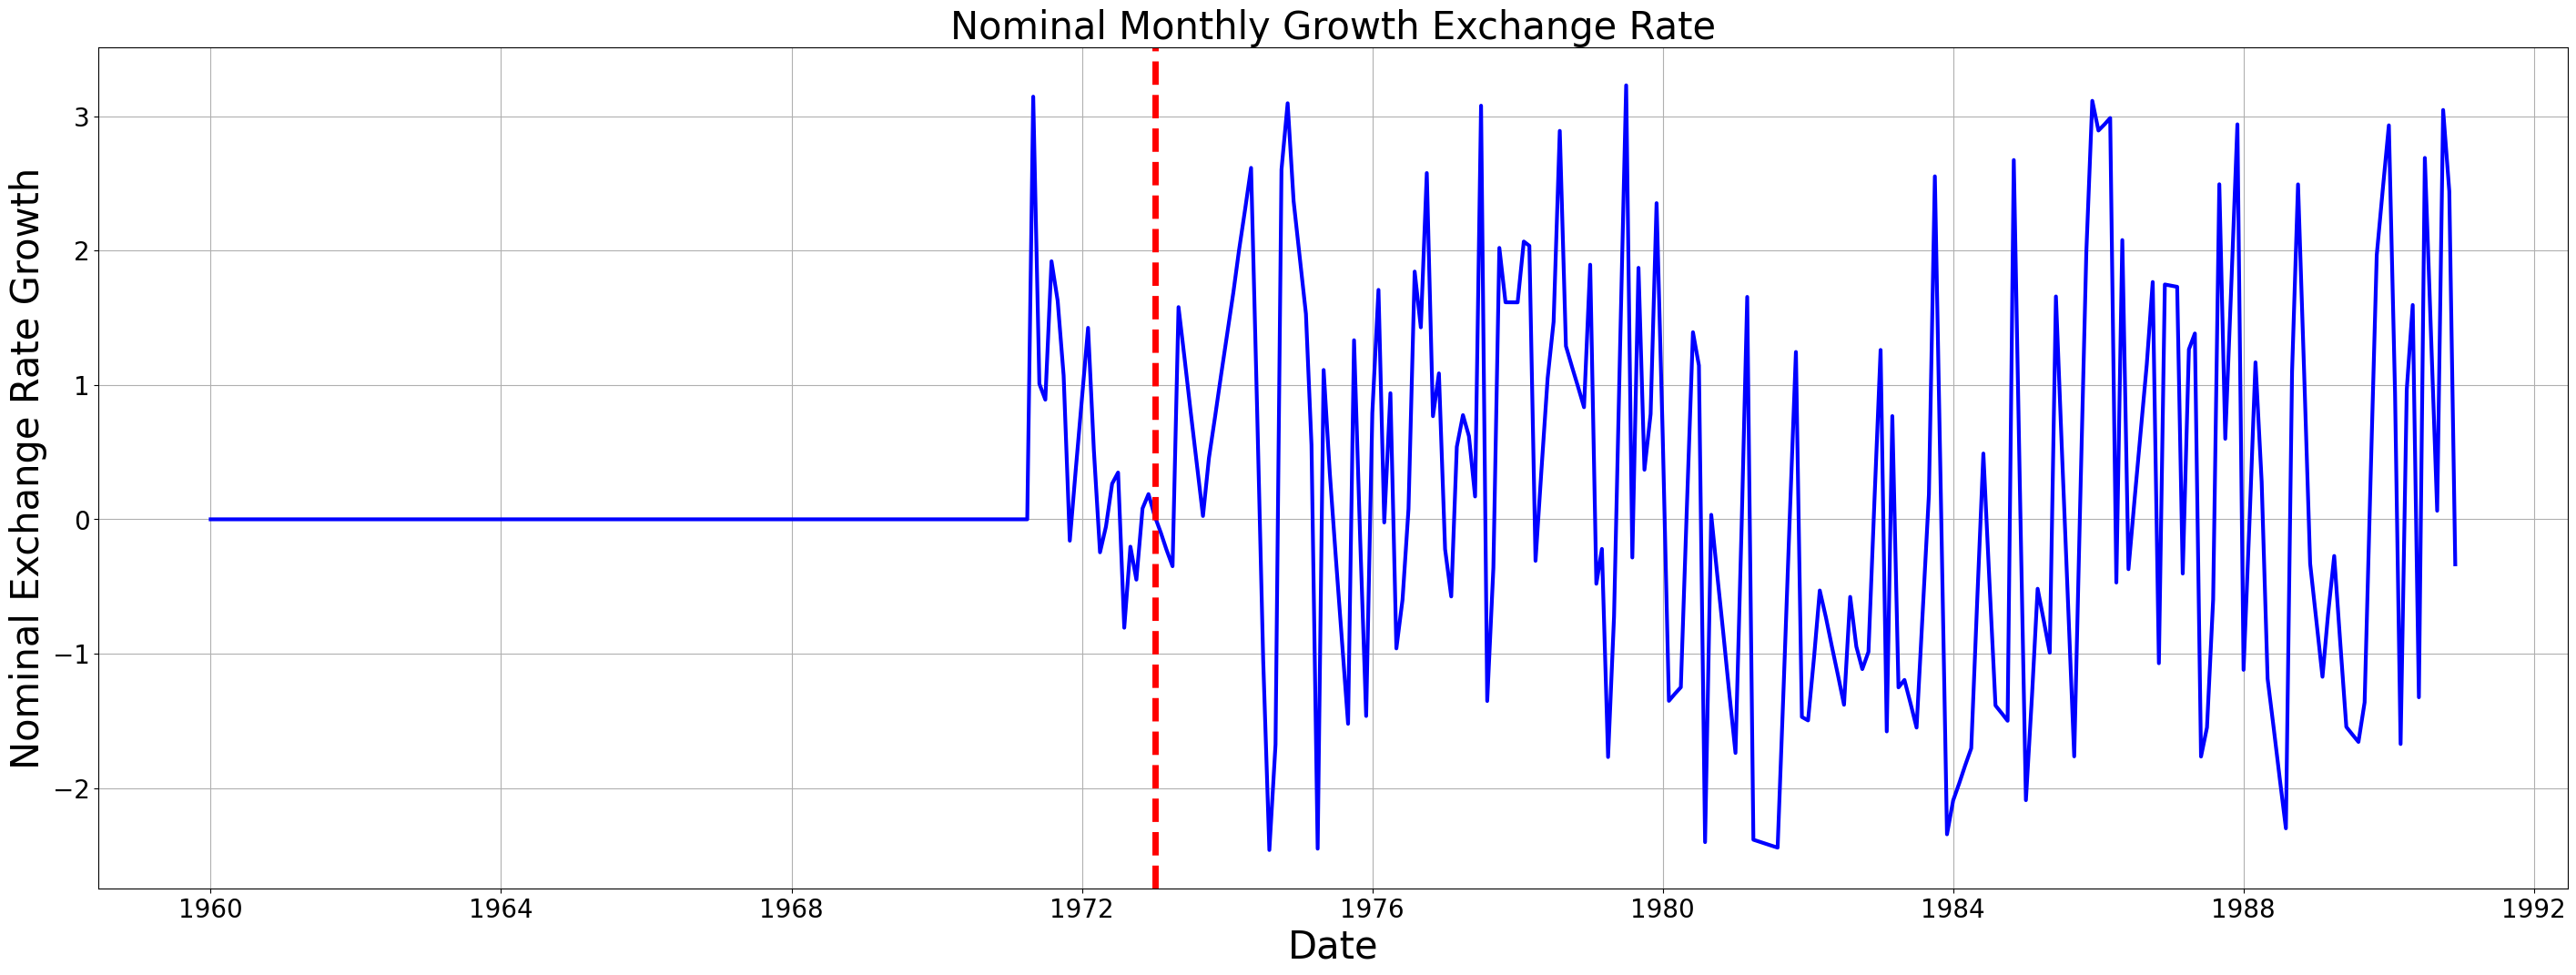

In [17]:
# Plot a time series graph of the monthly growth in nominal exchange rates of your country, versus the US dollar.
df_edited_germany = interpolate_missing_data(df_modified_germany)
df_edited_usa = interpolate_missing_data(df_modified_usa)

plt.figure(figsize=(35, 12))  
plt.plot(df_edited_germany.index, df_edited_germany['Nominal_Monthly_Growth_Exchange_Rate'], marker='', linestyle='-', color='b', linewidth=3)


plt.title('Nominal Monthly Growth Exchange Rate', size=(30))
plt.xlabel('Date', size=(30))
plt.ylabel('Nominal Exchange Rate Growth', size=(30))
plt.grid(True)
plt.xticks(size=(20))  
plt.yticks(size=(20))

plt.axvline(x=1100, color='red', linestyle='dashed', linewidth=5)
plt.show()



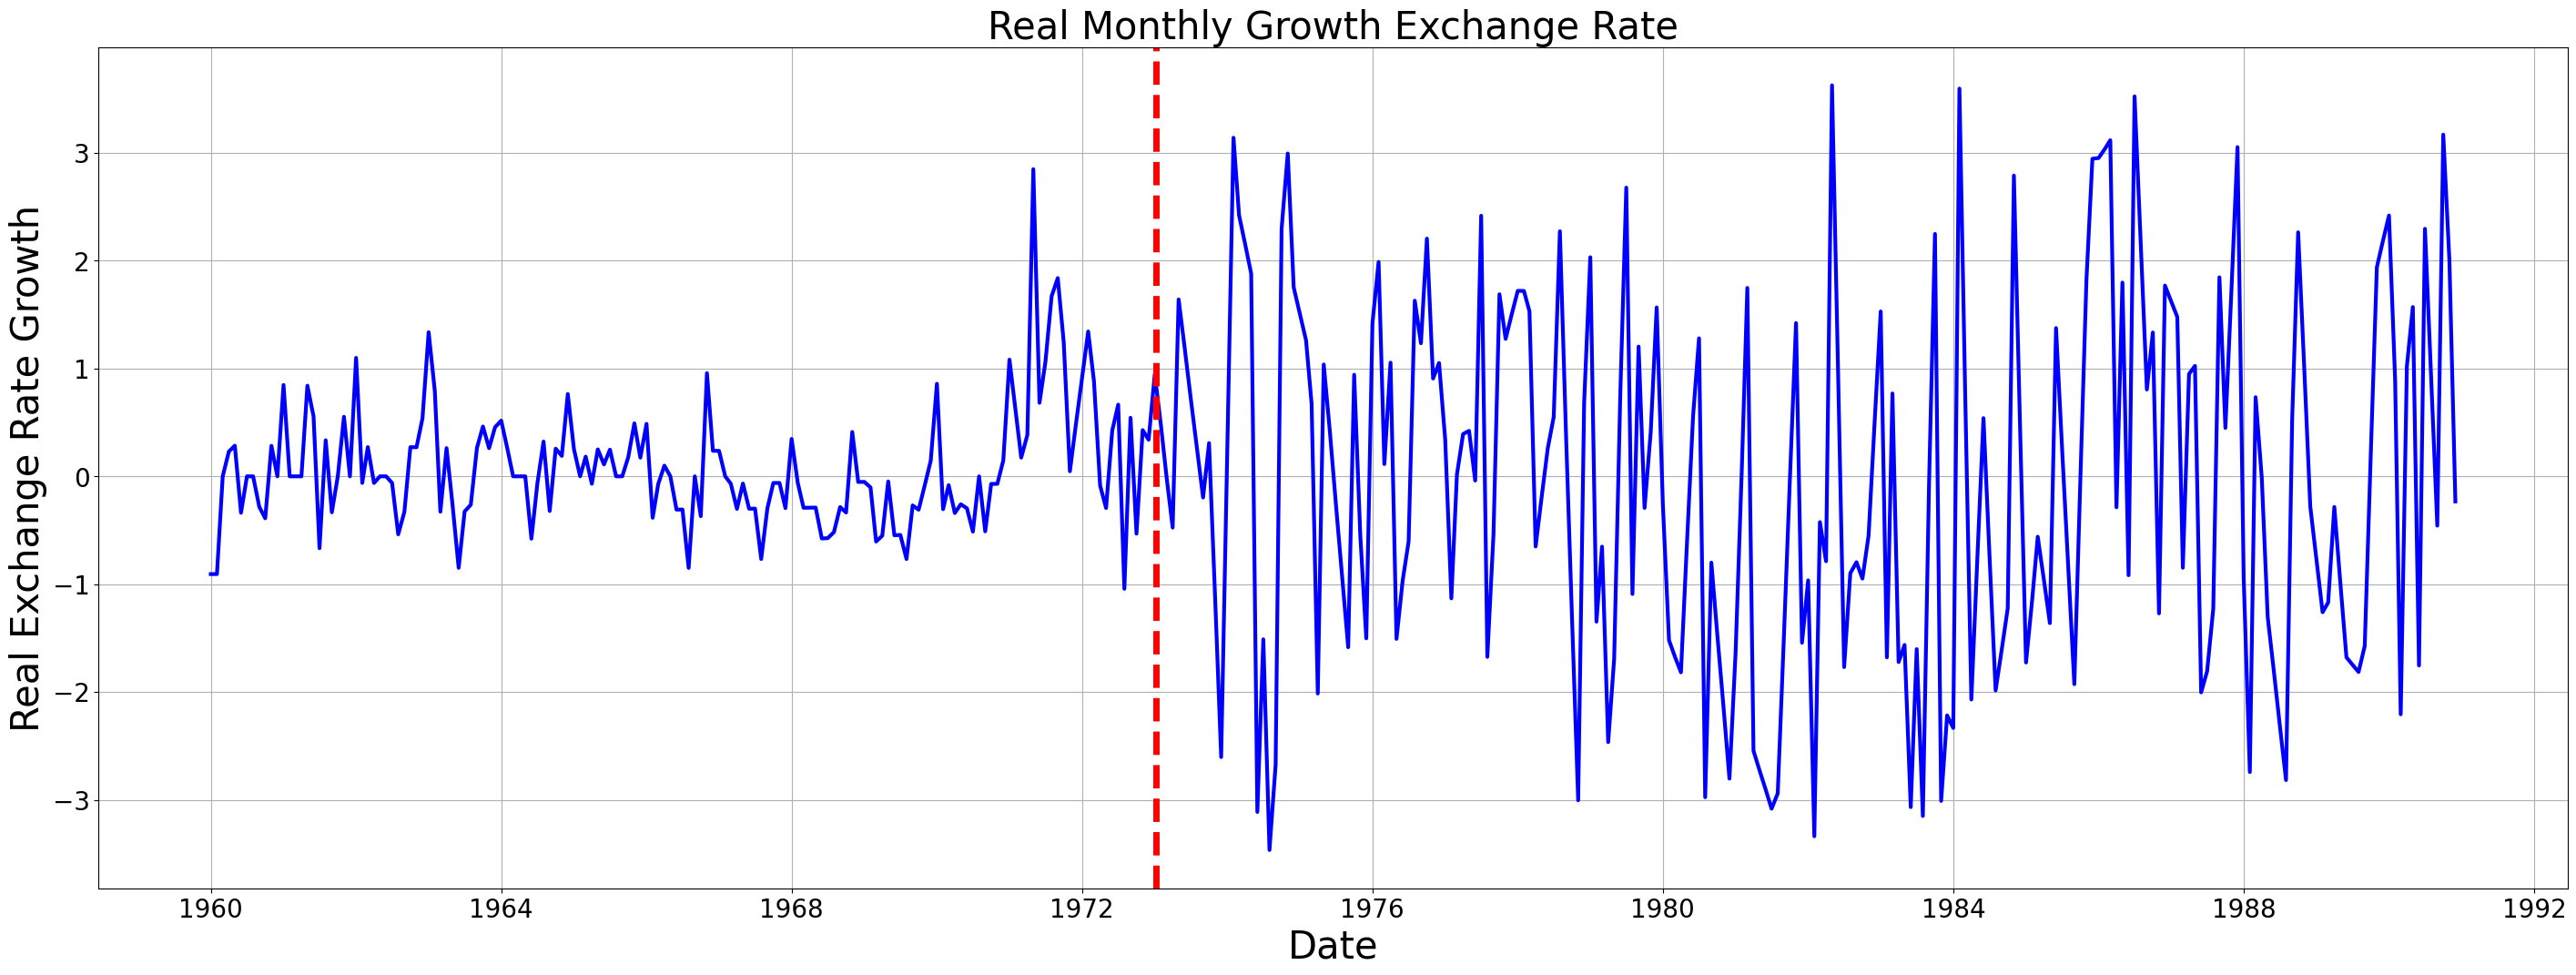

In [18]:
# Plot a time series graph of the monthly growth in real exchange rates of your country, versus the US dollar.
df_edited_germany = interpolate_missing_data(df_modified_germany)

plt.figure(figsize=(35, 12))  
plt.plot(df_edited_germany.index, df_edited_germany['Real_Monthly_Growth_Exchange_Rate'], marker='', linestyle='-', color='b', linewidth=3)


plt.title('Real Monthly Growth Exchange Rate', size=(30))
plt.xlabel('Date', size=(30))
plt.ylabel('Real Exchange Rate Growth', size=(30))
plt.grid(True)
plt.xticks(size=(20))  
plt.yticks(size=(20))

plt.axvline(x=1100, color='red', linestyle='dashed', linewidth=5)

plt.show()

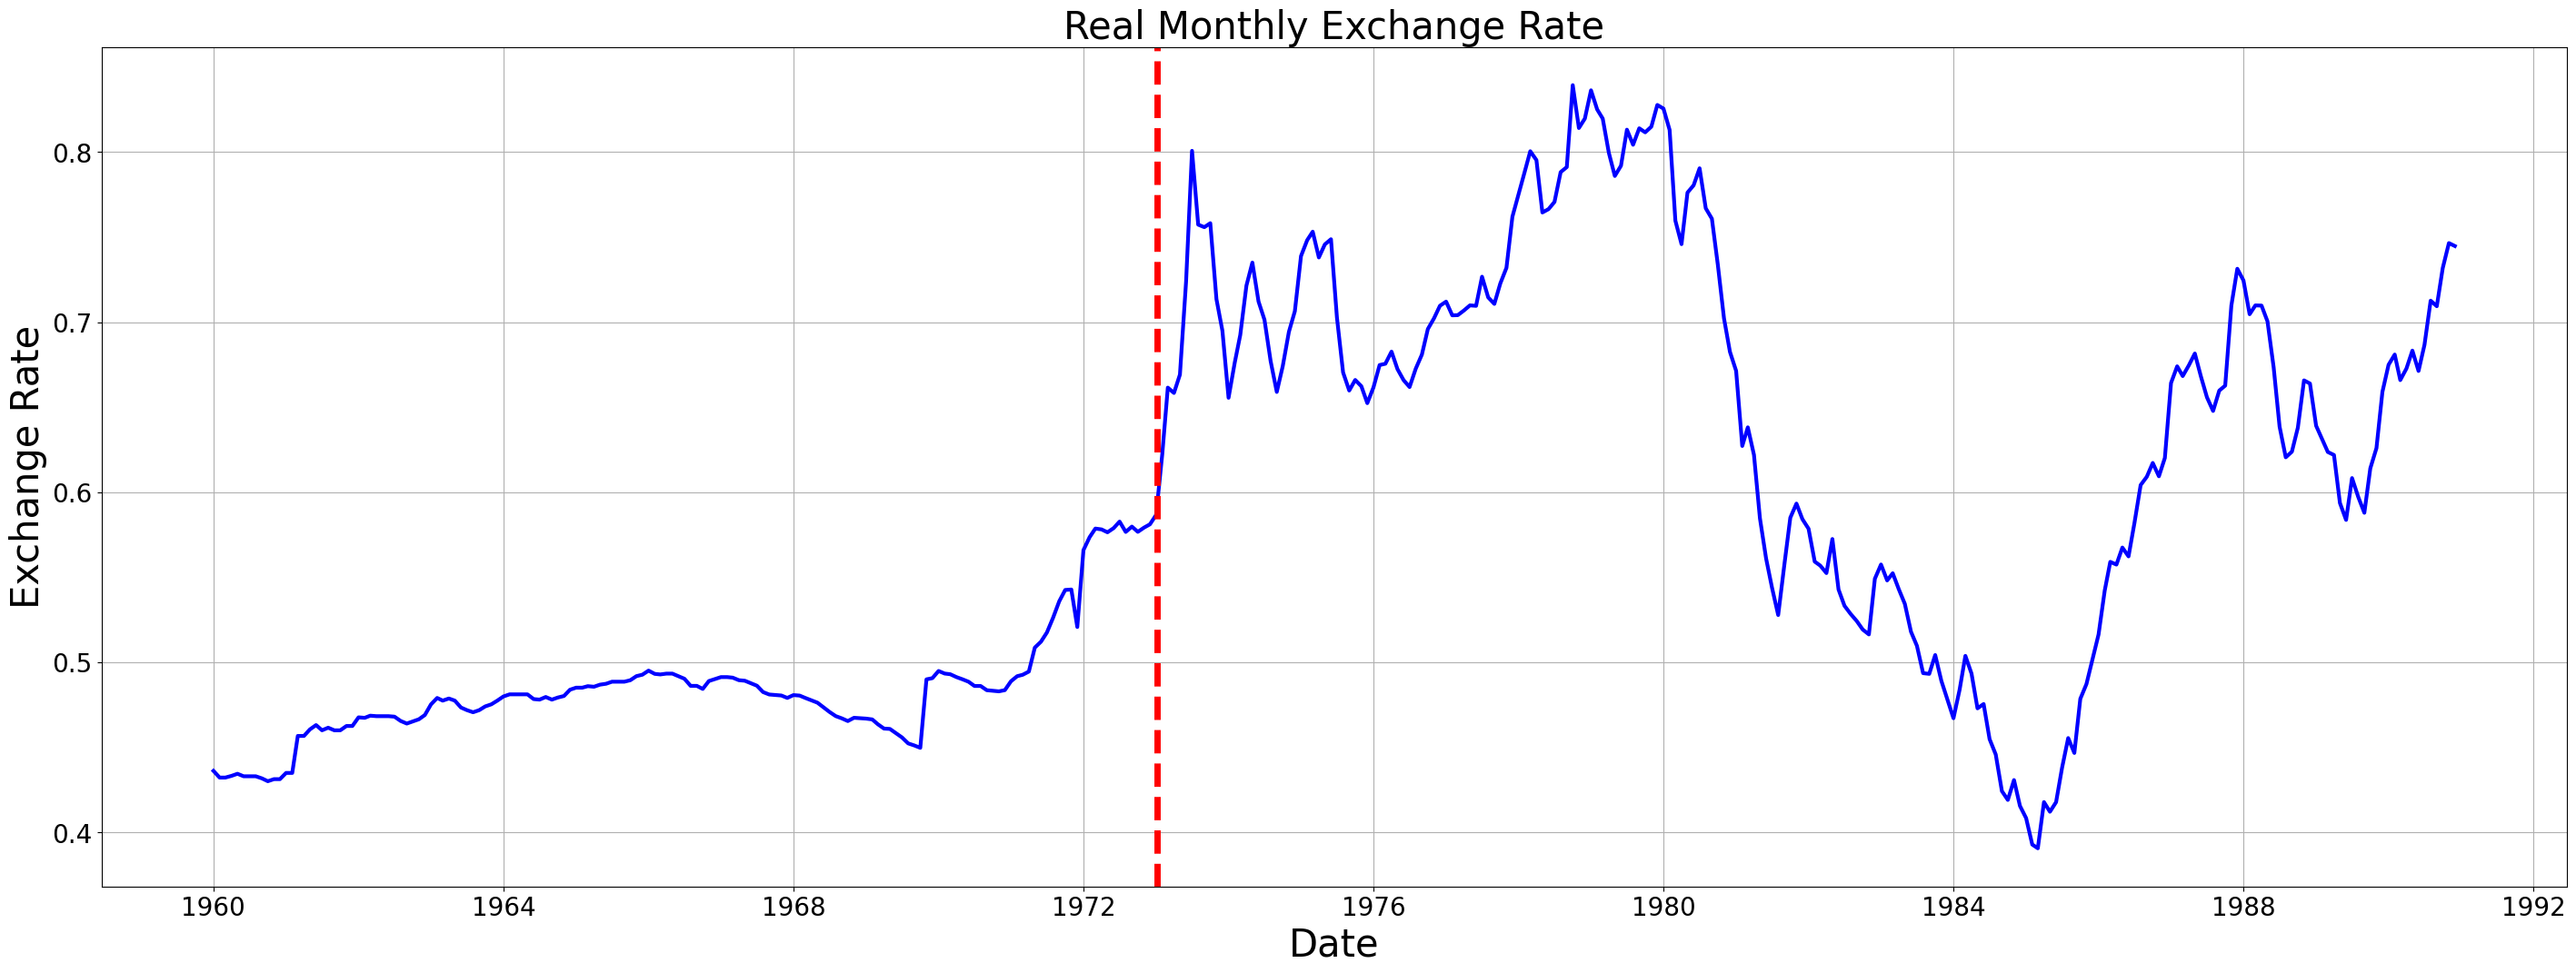

In [19]:
#Plot a time series graph of the real exchange rate level of your country, versus the US dollar.

plt.figure(figsize=(35, 12))
plt.plot(df_edited_germany.index, df_edited_germany['Real_Monthly_Exchange_Rate'], marker='', linestyle='-', color='b', linewidth=3)



plt.title('Real Monthly Exchange Rate', size=(30))
plt.xlabel('Date', size=(30))
plt.ylabel('Exchange Rate', size=(30))
plt.grid(True)
plt.xticks(size=(20))  
plt.yticks(size=(20))

plt.axvline(x=1100, color='red', linestyle='dashed', linewidth=5)

plt.show()

### Question: Why is it useful to plot both real and nominal exchange rate growth?
**1. Inflationary Effects**
Plotting both nominal and real exchange rates help us to identify if nominal changes reflect actual changes in the value of currencies or simply inflation differences between countries.

**2. Analyzing Competitiveness**
For example, a rising real exchange rate can indicate a loss in export competitiveness, as imported goods become cheaper, and exported goods become relatively expensive in the global market.

**3. Identifying Underlying Factors**
Deviations between real and nominal exchange rate movements can suggest other factors at play beyond just exchange rate adjustments.
For example, a rise in nominal exchange rate coupled with a decrease in real exchange rate might indicate increased productivity or efficiency in the domestic economy. As such, plotting both rates allows for a more nuanced understanding of the factors influencing exchange rate dynamics.

### Question: Was the US dollar over or undervalued in the Bretton Woods system? Refer to data or figures in your answer.
The US dollar was seen to be overvalued in the Bretton Wood system. The uptrend in the plotted graph of Germany's real exchange rate level (compared to US) shows an appreciation of Germany's currency during the period under the Bretton Woods. As such, the US dollar was losing value relative to foreign currencies like Germany.

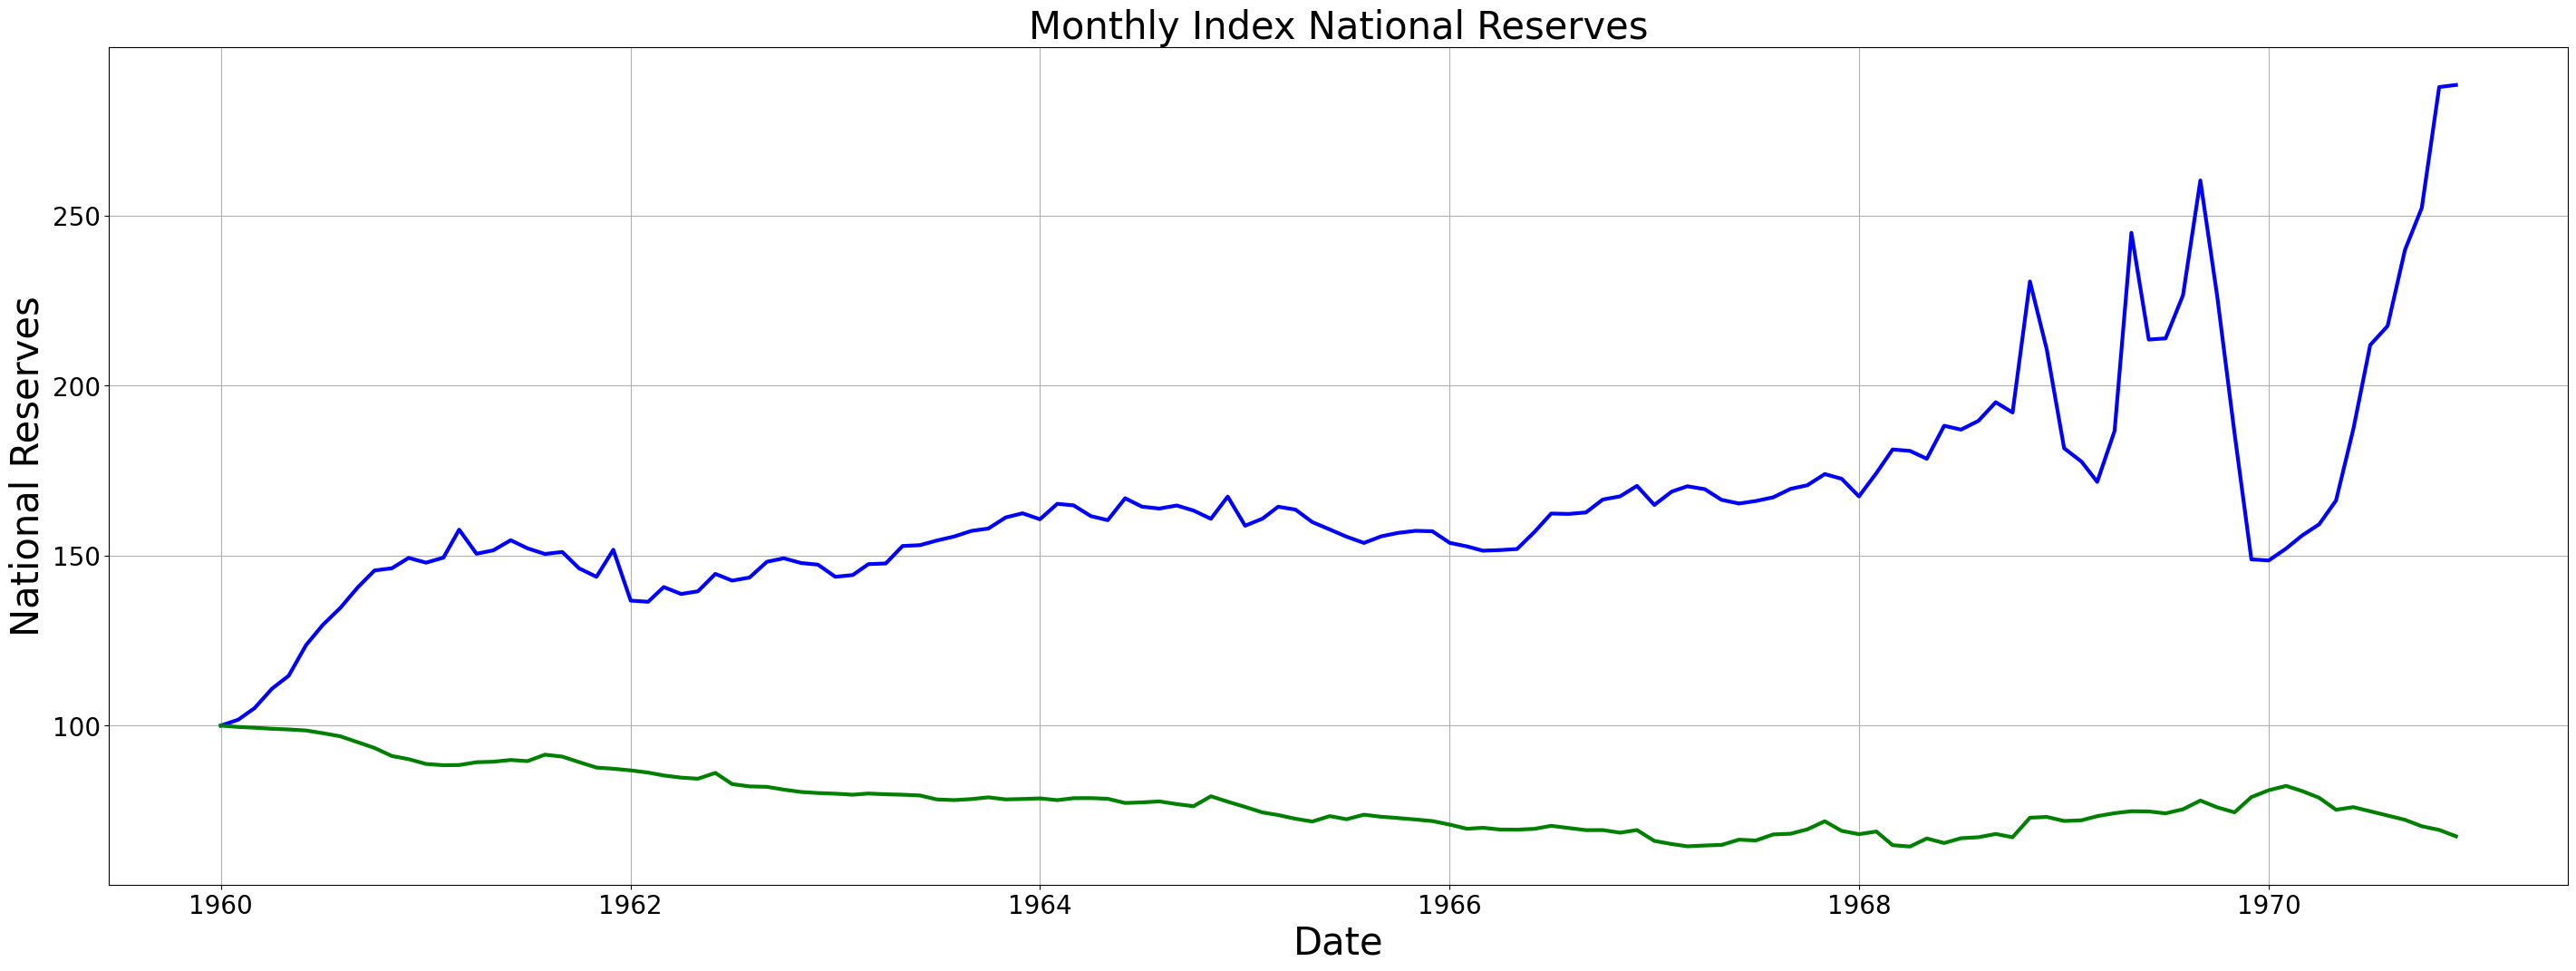

In [20]:
# Plot a time series graph of the monthly indexed value of international reserves of your country 
# and the US from January 1960 until the exit of the US from Bretton Woods.

plt.figure(figsize=(35, 12))

# Plot until the exit of the US from Bretton Woods (1971)
limit_year = 1971
df_germany_filtered = df_edited_germany[df_edited_germany.index.year < limit_year]
df_usa_filtered = df_edited_usa[df_edited_usa.index.year < limit_year]

plt.plot(df_germany_filtered.index, df_germany_filtered['Index_National_Reserves'], marker='', linestyle='-', color='b',linewidth=3)
plt.plot(df_usa_filtered.index, df_usa_filtered['Index_National_Reserves'], marker='', linestyle='-', color='g', linewidth=3)

plt.title('Monthly Index National Reserves', size=(30))
plt.xlabel('Date', size=(30))
plt.ylabel('National Reserves', size=(30))
plt.grid(True)
plt.xticks(size=(20))  
plt.yticks(size=(20))

plt.show()

### Question: Using your above figures, explain one reason for the US’s departure from the Bretton Woods system.

As countries accumulated trade surpluses with the US, they exchanged their excess dollars for gold, as the dollar was pegged to gold under the Bretton Woods system. **This continuous drain on US gold reserves** made it increasingly difficult for the US to maintain the convertibility of dollars to gold at the fixed rate, as evidenced by the fall in national reserves over time, thus prompting the US's departure from the Bretton Woods system.

## 5.3.2 Inflation and Industrial Production Graphs

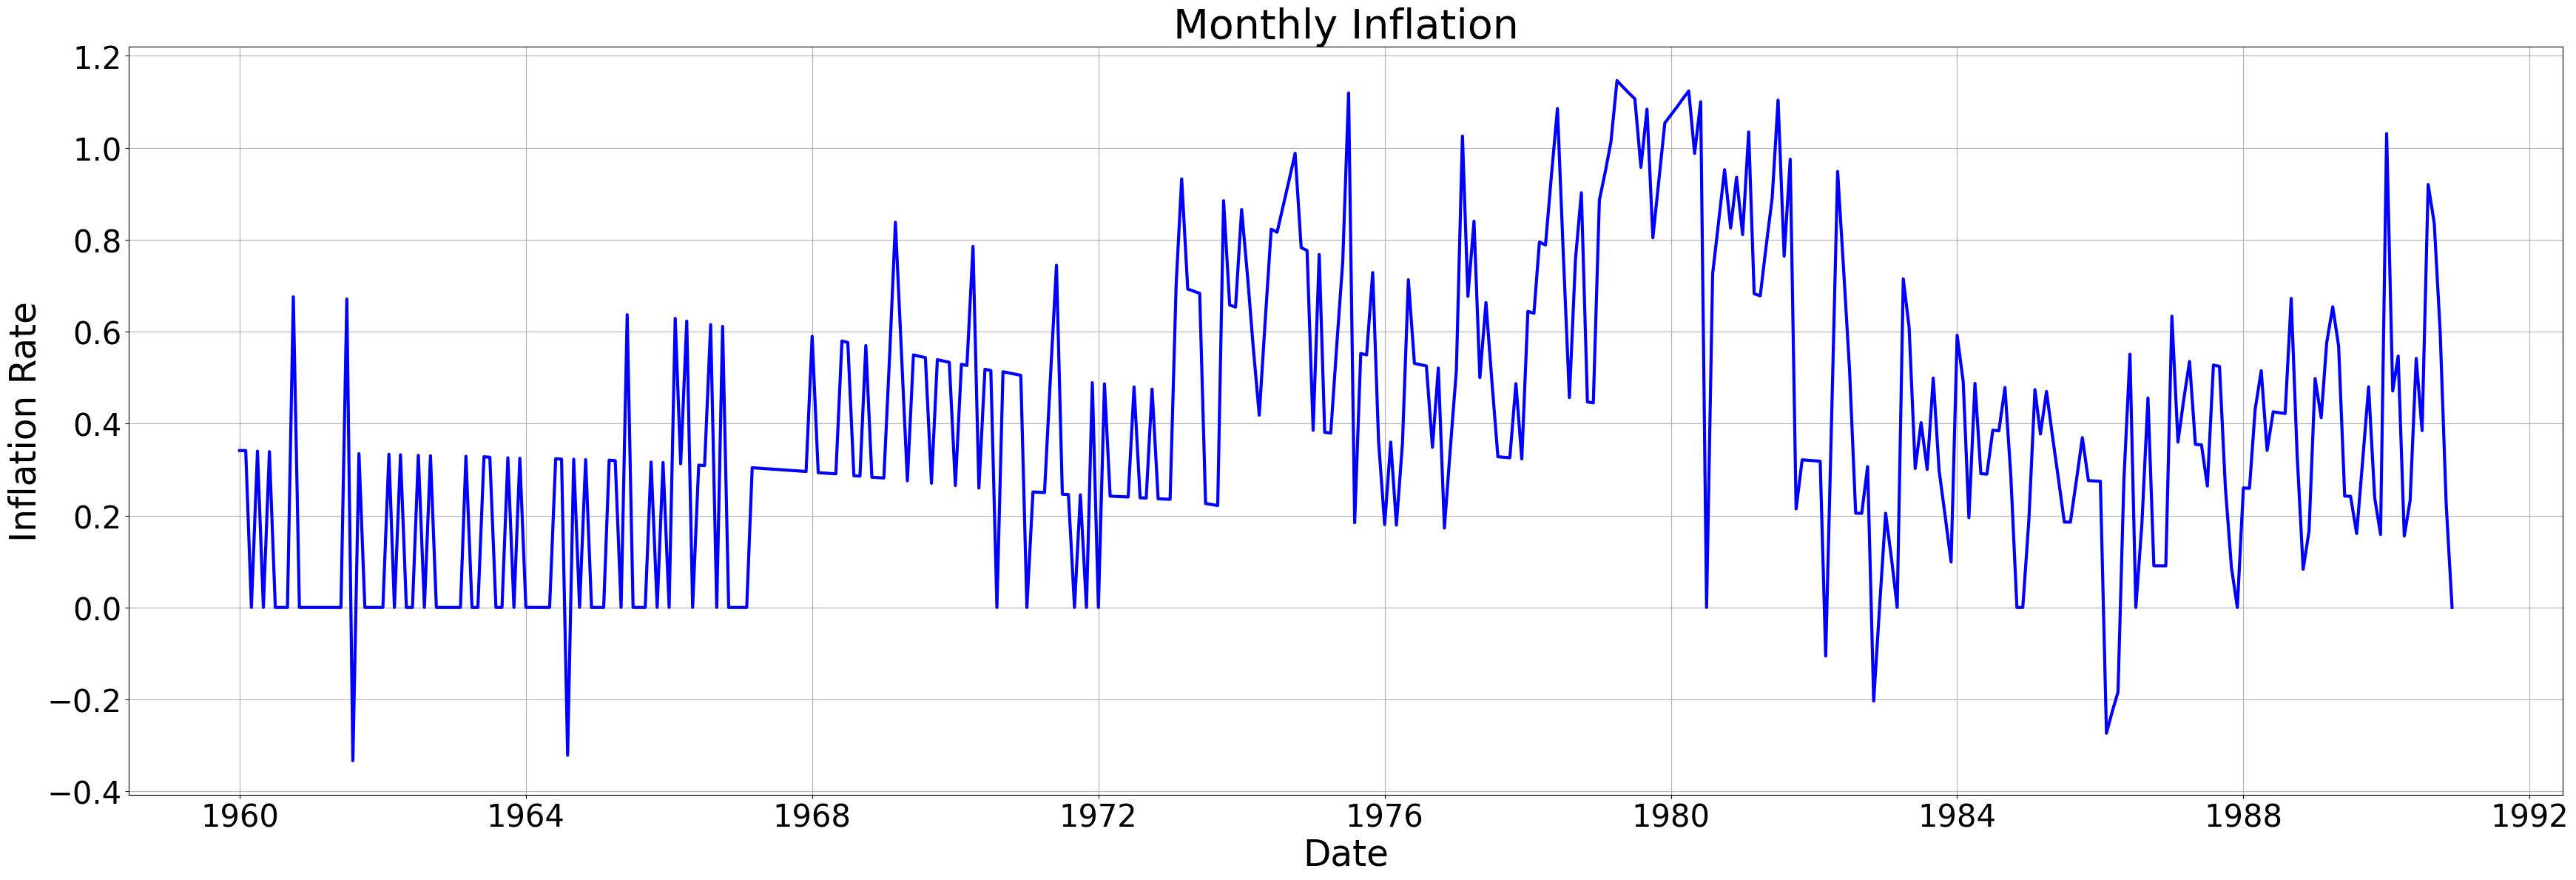

In [21]:
df_final_usa = interpolate_missing_data(df_modified_usa)

plt.figure(figsize=(35, 12))  
plt.plot(df_final_usa.index, df_final_usa['Monthly_Inflation_Rate'], marker='', linestyle='-', color='b', linewidth=3)
plt.title('Monthly Inflation', size=(40))
plt.xlabel('Date', size=(35))
plt.ylabel('Inflation Rate', size=(35))
plt.grid(True)
plt.xticks(size=(30)) 
plt.yticks(size=(30)) 
plt.tight_layout()  

plt.show()

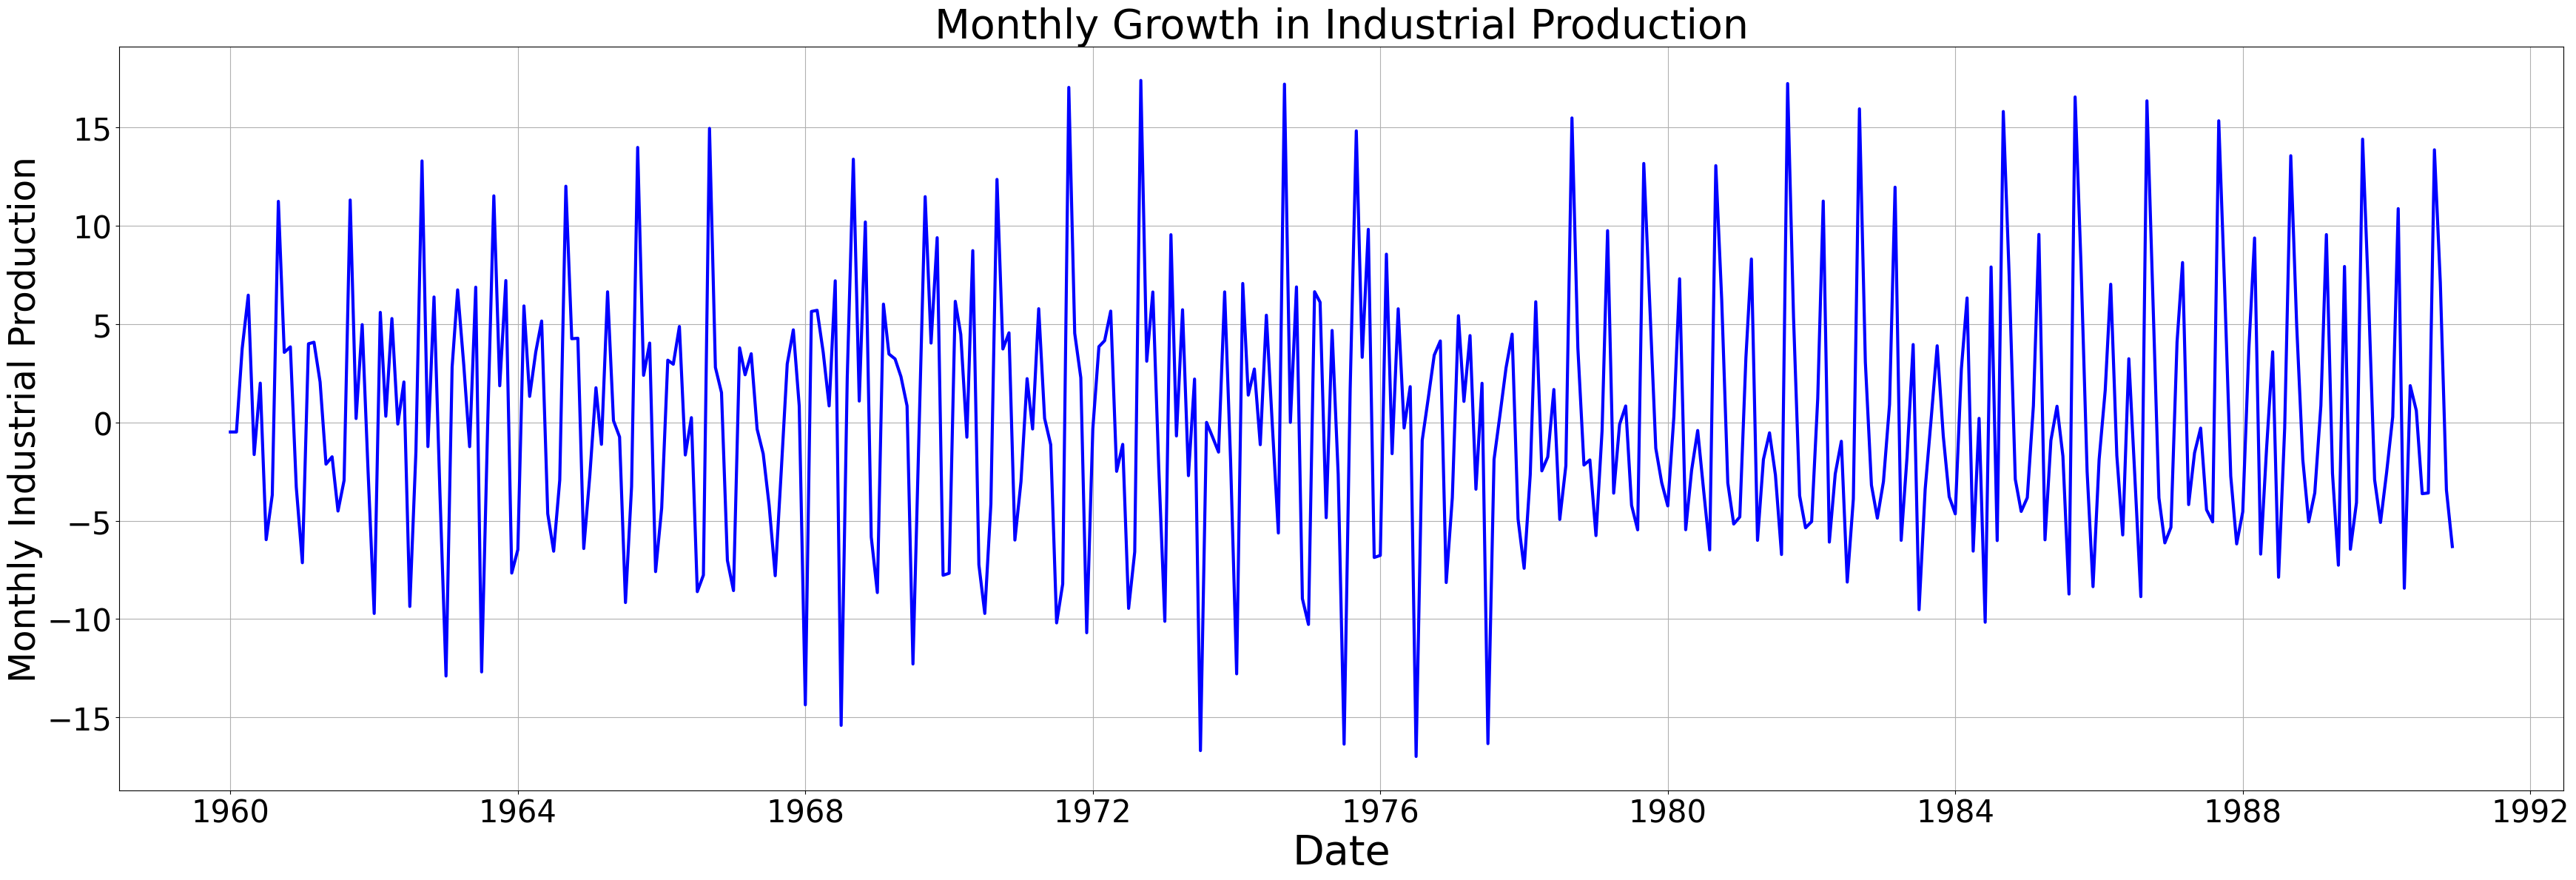

In [22]:
df_final_germany = interpolate_missing_data(df_modified_germany)

plt.figure(figsize=(35, 12))  
plt.plot(df_final_germany.index, df_final_germany['Monthly_Growth_Industrial_Production'], marker='', linestyle='-', color='b', linewidth=3)
plt.title('Monthly Growth in Industrial Production', size=(40))
plt.xlabel('Date', size=(40))
plt.ylabel('Monthly Industrial Production', size=(35))
plt.grid(True)
plt.xticks(size=(30))
plt.yticks(size=(30))
plt.tight_layout()  

plt.show()

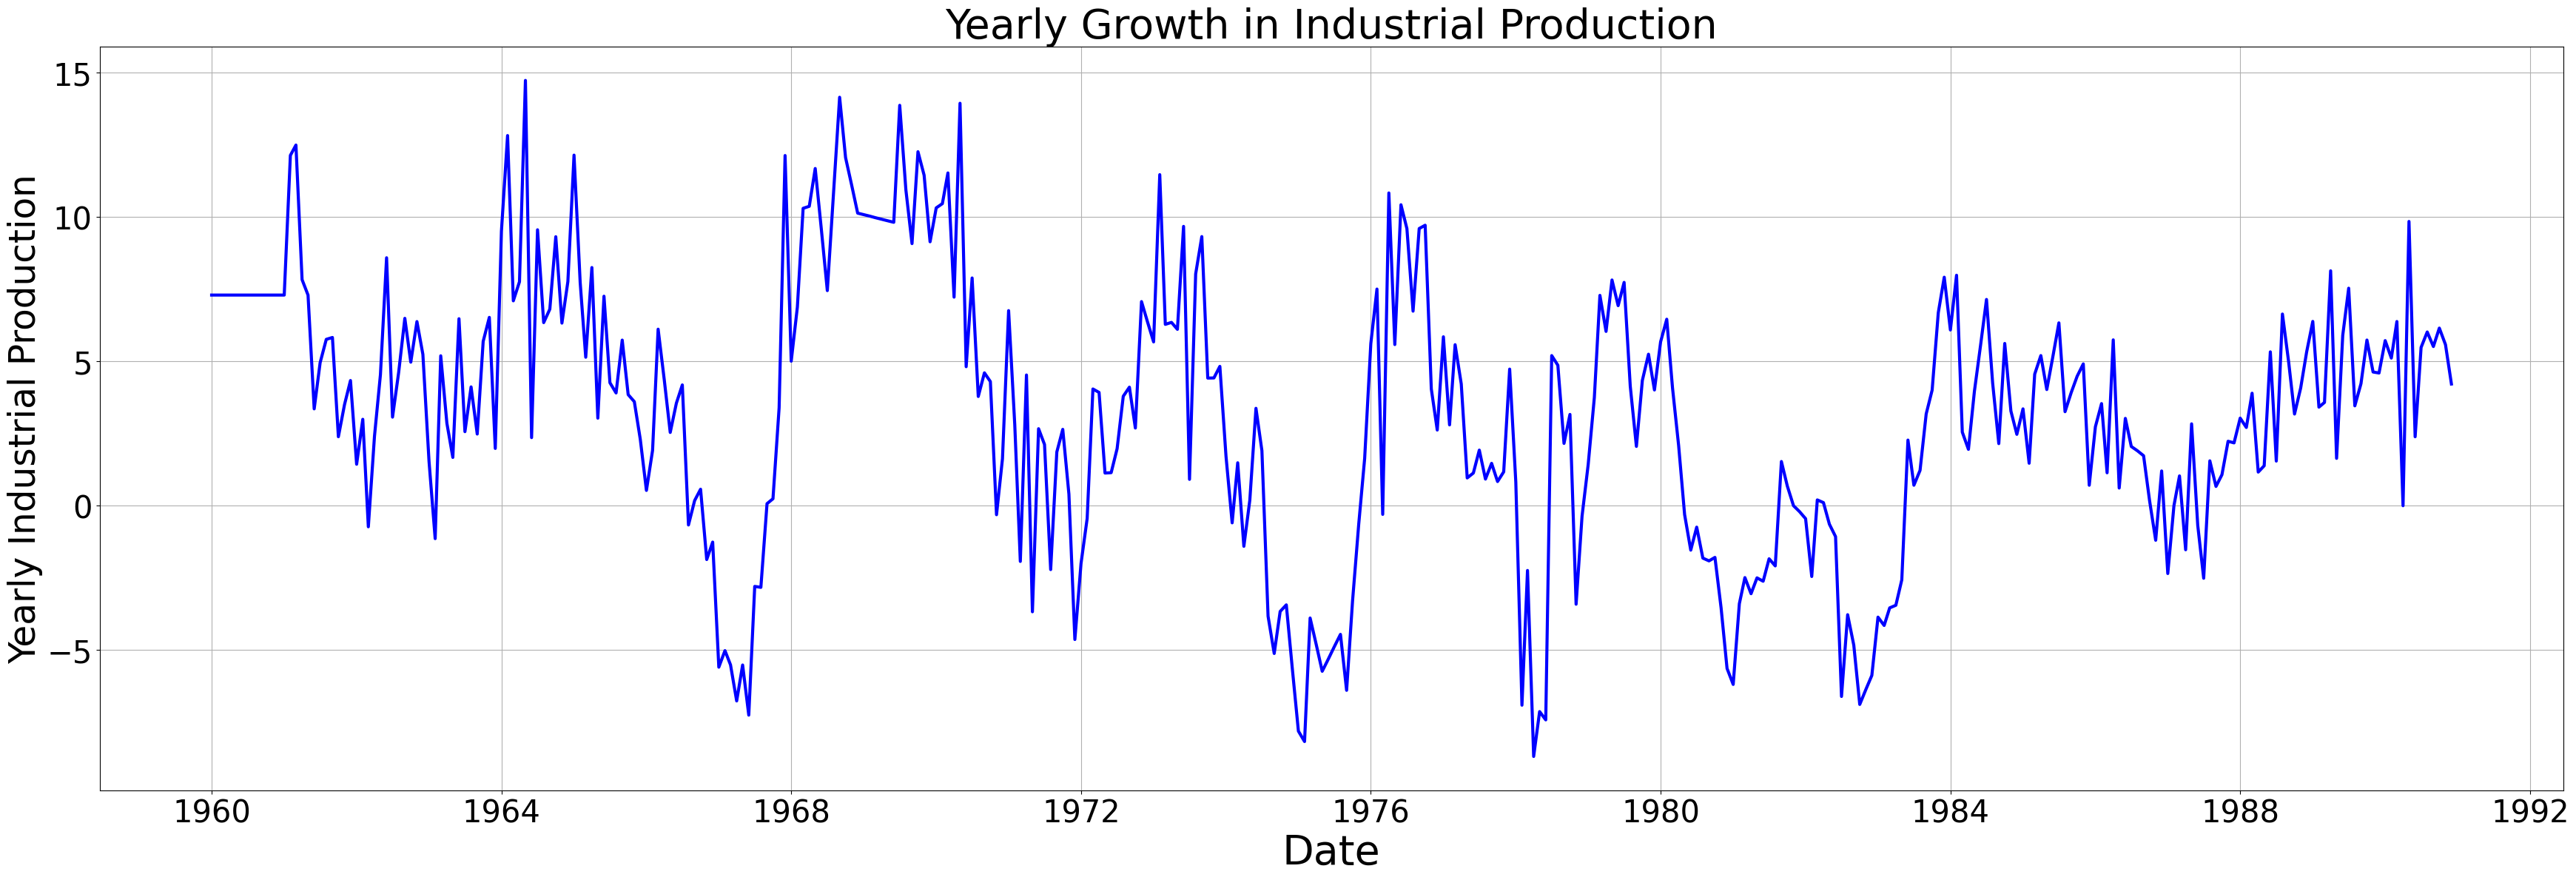

In [23]:
plt.figure(figsize=(35, 12))  
plt.plot(df_final_germany.index, df_final_germany['Yearly_Growth_Industrial_Production'], marker='', linestyle='-', color='b', linewidth=3)
plt.title('Yearly Growth in Industrial Production', size=(40))
plt.xlabel('Date', size=(40))
plt.ylabel('Yearly Industrial Production', size=(35))
plt.grid(True)
plt.xticks(size=(30))
plt.yticks(size=(30))  
plt.tight_layout()  

plt.show()

The difference can be attributed to a several factors: 

1. **Seasonal Variations:** Monthly data are subject to significant seasonal variations, whereas 12-monthly growth rate helps smooth out these seasonal effects. 
2. **Different Time Horizon:** Monthly data is more volatile, reflecting short-term fluctuations in economic activity. The 12-monthly growth rate provides a clearer picture of the underlying long-term trend, as it averages out these short-term volatilities coupled with mean reversion.
3. **Time Lags:** Impact of economical policies or exogenous shocks might not be fully visible in the monthly data but can become more apparent when looking at year-on-year changes. This longer term view better captures the cumulative effects of such events. 

The usefulness of both datasets depends on the specific needs of the analysis: 
1. **Responding to immediate economic conditions:** Monthly data allows policymakers to make decisions based on the most current information available.
2. **Appreciation of Longer Term Trends:** The 12-monthly growth dataset will be more informative in unravelling the underlying momentum in economic movements, which are less affected by short-term volatility and sesonality.

# 5.3.3 Comparison Statistics

In [24]:
# Define the periods
periods = ['Before Bretton Woods', 'After Bretton Woods']
dates_germany = df_edited_germany.index.get_level_values(0)
dates_usa = df_edited_usa.index.get_level_values(0)

# Initialize an empty dictionary to store the results
std_dict = {}

# Iterate over the periods
for period in periods:
    # Filter the data for that particular period
    if period == 'Before Bretton Woods':
        df_period = df_edited_germany.loc[dates_germany <= '1971-07-01']
        dates_period = dates_usa[dates_usa <= '1971-07-01']
    else:
        df_period = df_edited_germany.loc[dates_germany >= '1973-01-01']
        dates_period = dates_usa[dates_usa >= '1973-01-01']
    
    # Calculate the standard deviations for the period
    std_nominal_monthly_growth_exchange_rate = df_period['Nominal_Monthly_Growth_Exchange_Rate'].std()
    std_real_monthly_growth_exchange_rate = df_period['Real_Monthly_Growth_Exchange_Rate'].std()
    std_inflation = df_period['Monthly_Inflation_Rate'].std()
    std_industrial_production = df_period['Yearly_Growth_Industrial_Production'].std()
    std_inflation_difference = (df_period['Monthly_Inflation_Rate'] - df_edited_usa.loc[dates_period]['Monthly_Inflation_Rate']).std()
    
    # Store the results in the dictionary
    std_dict[period] = [std_nominal_monthly_growth_exchange_rate, std_real_monthly_growth_exchange_rate, std_inflation, std_industrial_production, std_inflation_difference]

# Create a DataFrame from the dictionary
std_df = pd.DataFrame(std_dict, index=['Nominal Monthly Growth Exchange Rate', 'Real Monthly Growth Exchange Rate', 'Monthly Inflation Rate', 'Yearly Growth Industrial Production', 'Inflation Difference'])

# Calculate the ratio of standard deviations
std_df['Ratio'] = std_df['After Bretton Woods'] / std_df['Before Bretton Woods']


# Display the DataFrame
std_df
# Changed the background color of the whole DataFrame to blue and the border colour to yellow, make the border thicker and the font colour to white for better visibility
std_df.style.set_table_styles([{'selector': '','props': []}])



,Before Bretton Woods,After Bretton Woods,Ratio
Nominal Monthly Growth Exchange Rate,0.288884,1.500105,5.192767
Real Monthly Growth Exchange Rate,0.492966,1.698255,3.444971
Monthly Inflation Rate,0.336257,0.299729,0.891370
Yearly Growth Industrial Production,4.634501,4.280271,0.923567
Inflation Difference,0.407196,0.333282,0.818482


# 5.4 Conclusion

In [25]:
import pandas as pd
# Filter the DataFrame to include only data before and after 1973-03-01
df_before_1973 = df_edited_germany[df_edited_germany.index < '1973-03-01']
df_after_1973 = df_edited_germany[df_edited_germany.index >= '1973-03-01']

# Define columns and calculations
columns = ['Exchange Rates, US Dollar per Domestic Currency, Period Average, Rate', 'Real_Monthly_Exchange_Rate', 'Economic Activity, Industrial Production, Index', 'Monthly_Inflation_Rate']
before_averages = [df_before_1973[col].mean() for col in columns]
after_averages = [df_after_1973[col].mean() for col in columns]

# Create a DataFrame to display the results as a table
data = {
    'Before Bretton Woods': before_averages,
    'After Bretton Woods': after_averages
}
index = [
    'Average Nominal Monthly Exchange Rate',
    'Average Real Monthly Exchange Rate',
    'Average Industrial Production',
    'Average Monthly Inflation Rate'
]
df_growth_rates = pd.DataFrame(data, index=index)

# Display the DataFrame
df_growth_rates






,Before Bretton Woods,After Bretton Woods
Average Nominal Monthly Exchange Rate,0.259448,0.461472
Average Real Monthly Exchange Rate,0.485570,0.647790
Average Industrial Production,46.848353,69.214070
Average Monthly Inflation Rate,0.243305,0.282679
